# Convolutional Neural Networks for digit image classification

The popular [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digit image classification dataset contains 60′000 + 10′000 hand- written digits to be classified as a number between 0 and 9.

The sequence of (more and more complex) models defined below will eventually arrive at the one suggested in this [tutorial](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

## Steps

1. Loading and plotting the mnist dataset
2. Setting the sceene for image classification 
3. Defining and evaluating the baseline model 
4. Adding Pooling
5. Adding a CNN Kernel
6. Adding another dense output layer

## Loading and plotting the MNIST dataset

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


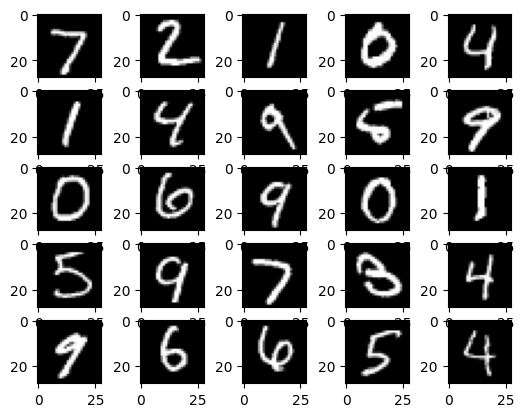

In [28]:
from tensorflow.keras.datasets.mnist import load_data 
from matplotlib import pyplot

# load dataset
(x_train, y_train), (x_test, y_test) = load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape)) 
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

# plot first few images
for i in range(25):
    # define subplot
    pyplot.subplot(5, 5, i+1)
    # plot raw pixel data
    pyplot.imshow(x_test[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

## Setting the sceene for image classification

Fix necessary imports.

In [72]:
import numpy as np
import random
from numpy import zeros
from numpy import unique
from numpy import argmax
from numpy import asarray
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.metrics import Accuracy

Reshape data to have a single b/w channel.

In [30]:
orig_shape = x_train.shape[1:]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
in_shape = x_train.shape[1:]
print("Before: {0}".format(orig_shape))
print("After: {0}".format(in_shape))

Before: (28, 28)
After: (28, 28, 1)


Determine the number of classes.

In [31]:
n_classes = len(unique(y_train)) 
print("Classes: {0}".format(n_classes))

Classes: 10


Normalize pixel values `int[0..255]` $\rightarrow$ `float32[0..1]`.

In [32]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

Function to define the CNN model architecture and compile it with constant surrogate goal function (loss), evaluation metrics, and optimizer. We will vary depth, kernel_width, and pool_stride of the models.

In [121]:
def make_model(depth, kernel_width, pool_stride, add_dense=False, dense_structure=[100]):
    model = Sequential()
    model.add(Conv2D(depth, (kernel_width,kernel_width), activation='relu',input_shape=in_shape))
    model.add(MaxPool2D((pool_stride, pool_stride)))
    model.add(Flatten())
    if add_dense:
        for size in dense_structure:
            model.add(Dense(size, activation='relu'))
            model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return model

Define learning parameters for all models.

In [34]:
EPOCHS = 10
BATCH_SIZE = 128
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=10,
    mode='max', 
    restore_best_weights=True)
it = round(60000/BATCH_SIZE)

It takes {{it}} iterations to finish an epch.

Function to show the history of training.

In [35]:
def plot_metrics(history):
    colors = pyplot.rcParams['axes.prop_cycle'].by_key()['color'] 
    metrics = ['loss', 'accuracy'] 
    pyplot.figure(figsize=(10,5))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        pyplot.subplot(1,2,n+1)
        pyplot.plot(history.epoch, history.history[metric], color=colors[0],label='Train')
        pyplot.plot(history.epoch, history.history['val_'+ metric],color=colors[0], linestyle="--", label='Val') 
        pyplot.xlabel('Epoch')
        pyplot.ylabel(name)
        if metric == 'loss':
            pyplot.ylim([0, pyplot.ylim()[1] +0.1]) 
        else:
            pyplot.ylim([-0.1,1.1])
        pyplot.legend()

Function for setting random seeds

In [81]:
def set_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

## Baseline

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=1`, i.e., no effective CNN.

In [82]:
set_seeds()

baseline = make_model(1,1,1)
baseline.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 28, 28, 1)      │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         7,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,852 (30.67 KB)

 Trainable params: 7,852 (30.67 KB)

 Non-trainable params: 0 (0.00 B)

Note that the kernel has one weight and one bias, i.e., `Param = 2` for the CNN layer. The output of the CNN and the pooling layers are equal to their inputs.

We train the baseline model.

In [83]:
baseline_history = baseline.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7030 - loss: 1.0291 - val_accuracy: 0.9084 - val_loss: 0.3335
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9049 - loss: 0.3351 - val_accuracy: 0.9178 - val_loss: 0.2901
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9146 - loss: 0.2972 - val_accuracy: 0.9227 - val_loss: 0.2771
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9206 - loss: 0.2821 - val_accuracy: 0.9249 - val_loss: 0.2718
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9236 - loss: 0.2736 - val_accuracy: 0.9255 - val_loss: 0.2692
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9260 - loss: 0.2680 - val_accuracy: 0.9258 - val_loss: 0.2678
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9273 - loss: 0.2638 - val_accuracy: 0.9259 - val_loss: 0.2672
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9285 - loss: 0.2605 - val_accuracy: 0.

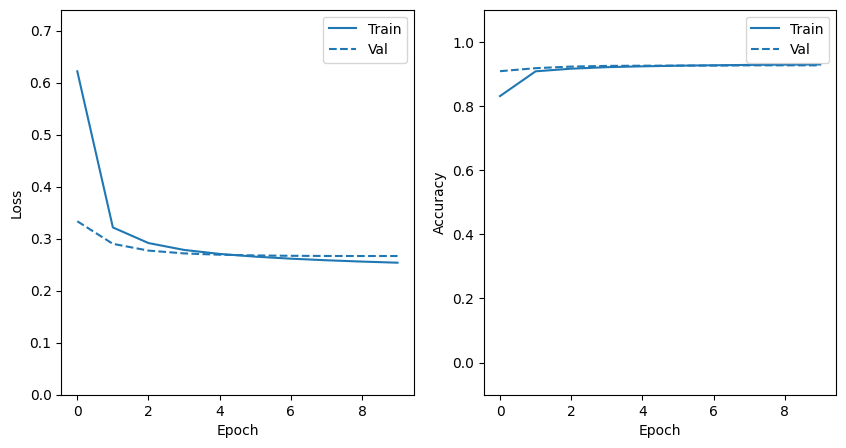

In [84]:
plot_metrics(baseline_history)

We do not observe effective learning. We evaluate the trained model.

In [85]:
loss, acc = baseline.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.908


Use the model to make a prediction.

In [86]:
xx = x_test[9]
xxx = asarray([xx])
yhat = baseline.predict(xxx)
argmax(yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


9

In [87]:
def print_res(model): 
    err = 0
    i_range = 10
    ys = zeros(i_range * i_range) 
    class bcolors:
        FAIL = '\033[91m'
        ENDC = '\033[0m' 
    for i in range(i_range):
        for j in range(i_range):
            idx = i*i_range+j
            image = x_test[idx]
            yhat = model.predict(asarray([image]))
            ys[idx] = argmax(yhat) 
            print('%d ' % ys[idx], end = '')
        print()
    print("--")
    for i in range(i_range): 
        for j in range(i_range):
            idx = i*i_range+j; 
            y = y_test[idx] 
            if y==ys[idx]:
                print('%d ' % y, end = '')
            else:
                err = err + 1
                print(f"{bcolors.FAIL}%d {bcolors.ENDC}" % y, end = '') 
        print()
    return err

In [88]:
err = print_res(baseline)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━

In [89]:
err

7

 The classic dense layer does perform good alone due to the fact that there are actually 7852 learnable parameters, i.e. 2 from the convolutional layer and 7850 from the dense layer. So a network with one hidden layer with the same size than the input layer would be sufficient either way. The target, therefore, is to reduce the parameters in the model while increasing the accuracy.

Baseline parameters:
- Model Complexity (Paramereters) = 7582
- Accuracy: 0.908
- Test error in first 100 images: 7

## Adding Pooling

We set `depth=1`, `kernel_width=1x1`, and `pool_stride=2`, i.e., no effective CNN and we even squeeze the image size, which would result in a less complex model.

In [91]:
set_seeds()
model1 = make_model(1,1,2, False)
model1.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 28, 28, 1)      │             2 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 14, 14, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         1,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,972 (7.70 KB)

 Trainable params: 1,972 (7.70 KB)

 Non-trainable params: 0 (0.00 B)

The kernel has still one weight and one bias, i.e., `Param = 2` for the CNN layer. The output of the pooling layers is one quater (half in each dimension) of the CNN in- and output. The dense layer got 1970 weights.

We train the first CNN model.

In [92]:
model1_history = model1.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5493 - loss: 1.4949 - val_accuracy: 0.8781 - val_loss: 0.4755
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8745 - loss: 0.4512 - val_accuracy: 0.8995 - val_loss: 0.3583
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8942 - loss: 0.3639 - val_accuracy: 0.9061 - val_loss: 0.3242
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9020 - loss: 0.3342 - val_accuracy: 0.9105 - val_loss: 0.3084
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9061 - loss: 0.3190 - val_accuracy: 0.9132 - val_loss: 0.2993
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9093 - loss: 0.3096 - val_accuracy: 0.9145 - val_loss: 0.2935
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9120 - loss: 0.3032 - val_accuracy: 0.9159 - val_loss: 0.2896
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9129 - loss: 0.2986 - val_accuracy: 0.

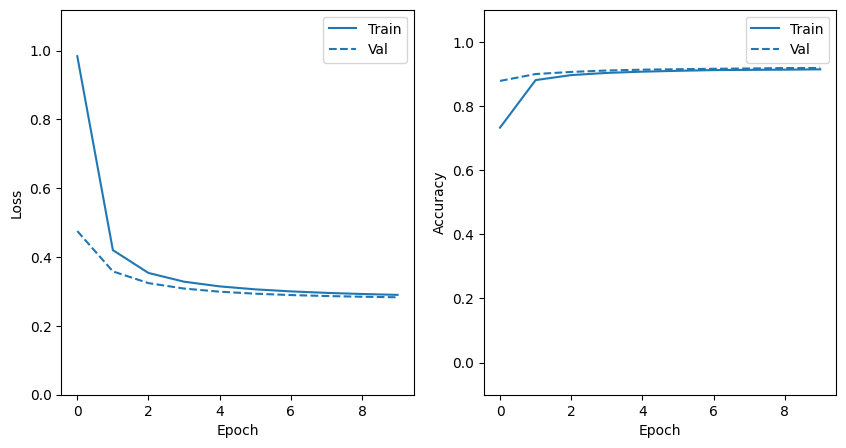

In [93]:
plot_metrics(model1_history)

We evaluate the trained model.

In [94]:
loss, acc = model1.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.878


This cannot be any better. Use the model to make a prediction.

In [95]:
err = print_res(model1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [96]:
err

13

The accuracy decreased as well as the number of parameters. However, the decrease in accuracy was about 0.03 and the reduce in the number of parameters was (7582 - 1972 = ) 5610, resulting in a much smaller model.


Model 1 Parameters:
- Model Complexity (Paramereters) = 1972
- Accuracy: 0.878
- Test error in first 100 images: 13


## Adding a CNN Kernel

Because we might assume, that evaluating more pixels together could compensate for the pool stride that might have caused the decrease of accuracy in the previous model. Additionally, we would decrease the complexity of the model one more time.

In [99]:
set_seeds()
model2 = make_model(1,3,2)
model2.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 26, 26, 1)      │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 13, 13, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 169)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 10)             │         1,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,710 (6.68 KB)

 Trainable params: 1,710 (6.68 KB)

 Non-trainable params: 0 (0.00 B)

The kernel has still 3 × 3 weights and one bias, i.e., `Param = 10` for the CNN layer. No padding is applied, so the CNN layer ‘eats’ one pixel at the corners, i.e., its output shape is `(26, 26, 1)`. The output of the pooling layers is one quater (half in x and y dimension) of the CNN output. Therefore, the weight for the dense layer were reduced to 1700.

We train the first real CNN model.

In [100]:
model2_history = model2.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5618 - loss: 1.3862 - val_accuracy: 0.8892 - val_loss: 0.3933
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8871 - loss: 0.3864 - val_accuracy: 0.9074 - val_loss: 0.3248
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9027 - loss: 0.3358 - val_accuracy: 0.9133 - val_loss: 0.3027
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9083 - loss: 0.3160 - val_accuracy: 0.9156 - val_loss: 0.2920
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9117 - loss: 0.3053 - val_accuracy: 0.9173 - val_loss: 0.2858
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9137 - loss: 0.2985 - val_accuracy: 0.9182 - val_loss: 0.2817
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9152 - loss: 0.2938 - val_accuracy: 0.9189 - val_loss: 0.2787
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9161 - loss: 0.2902 - val_accuracy: 0.

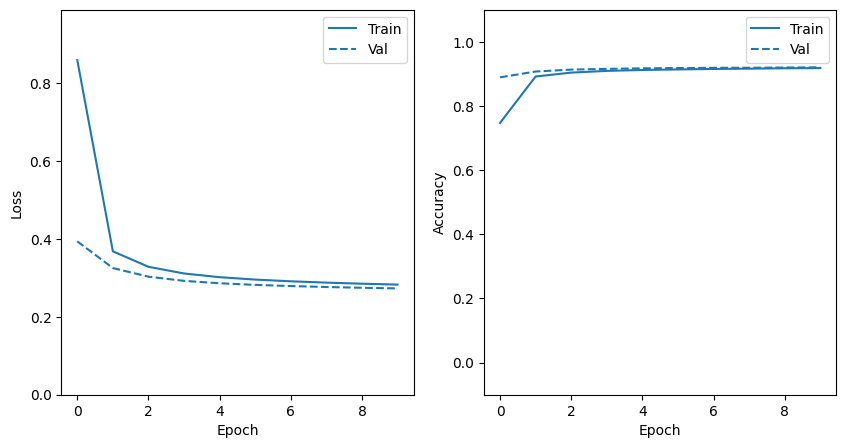

In [101]:
plot_metrics(model2_history)

Now we see effective training. We evaluate the trained model.

In [103]:
loss, acc = model2.evaluate(x_test, y_test, verbose=0) 
print('Accuracy: %.3f' % acc)

Accuracy: 0.889


Use the model to make a prediction.

In [104]:
err = print_res(model2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8

In [105]:
err

9

The accuracy increased a little bit about 0.011 while the complexity on the model decreased again by (1972-1710=) 262 compared to model 1.

Model 2 Parameters:
- Model Complexity (Paramereters) = 1710
- Accuracy: 0.889
- Test error in first 100 images: 9

The accuracy and the number of mistatakes in the first 100 images ({{err}}) drastically improved the baseline model.

## Adding Parallel CNN Kernels

We set `depth=32`, and keep `kernel_width=3x3`, and `pool_stride=2`. Because we assume that there are different filters/features that are relevant to classify the images. However, we pay for this with a much more weights in the dense layer as well as in the convolution layer.

In [107]:
set_seeds()
model3 = make_model(32,3,2)
model3.summary()

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │        54,090 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,410 (212.54 KB)

 Trainable params: 54,410 (212.54 KB)

 Non-trainable params: 0 (0.00 B)

There are 32 kernels has each with 3 × 3 weights and one bias, i.e., `Param = 320` for the CNN layer. As no padding is applied, the CNN layer’s output shape is the same for the x and y dimensions , but it adds depth: `(26, 26, 32)`. The output of the pooling layers is one quater (half in x and y dimension) of the CNN output, but it keeps the depth. Additionally, the dense layers weights grew to 54090.

We train the first CNN model.

In [108]:
model3_history = model3.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8311 - loss: 0.6482 - val_accuracy: 0.9596 - val_loss: 0.1408
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9636 - loss: 0.1337 - val_accuracy: 0.9730 - val_loss: 0.0893
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9763 - loss: 0.0879 - val_accuracy: 0.9778 - val_loss: 0.0725
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9812 - loss: 0.0696 - val_accuracy: 0.9790 - val_loss: 0.0654
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9836 - loss: 0.0594 - val_accuracy: 0.9801 - val_loss: 0.0615
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9855 - loss: 0.0524 - val_accuracy: 0.9800 - val_loss: 0.0587
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9868 - loss: 0.0471 - val_accuracy: 0.9810 - val_loss: 0.0568
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9881 - loss: 0.0427 - val_accuracy: 0.

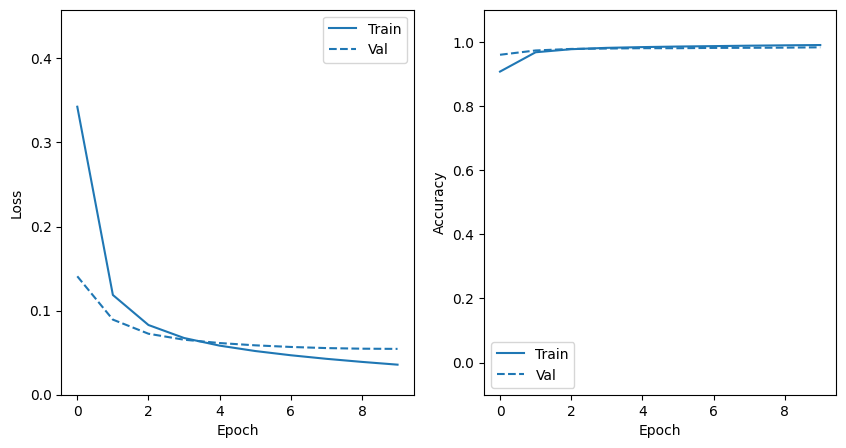

In [109]:
plot_metrics(model3_history)

In [110]:
loss, acc = model3.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.960


In [111]:
err = print_res(model3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [112]:
err

2

Here the accuracy goes up to 0.96 outperform all models trained so far. However, this is also the most complex model with a total parameter size of 54410 parameters.

Model 3 parameters:
- Model Complexity (Paramereters) = 54410
- Accuracy: 0.96
- Test error in first 100 images: 2


## Adding another dense (hidden) layer

Because we might assume, that the learning can be improved when applying a more complex network after the convolution layer. However, we pay for this one more time with a more complex model.

In [114]:
set_seeds()
model4 = make_model(32,3,2,True)
model4.summary()

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 5408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 100)            │       540,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,230 (2.07 MB)

 Trainable params: 542,230 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

This lets the number of parameters grow to over half a million!
We train this final CNN model.

In [115]:
model4_history = model4.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8085 - loss: 0.6309 - val_accuracy: 0.9715 - val_loss: 0.0883
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9590 - loss: 0.1445 - val_accuracy: 0.9787 - val_loss: 0.0644
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9704 - loss: 0.1011 - val_accuracy: 0.9807 - val_loss: 0.0540
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9749 - loss: 0.0851 - val_accuracy: 0.9828 - val_loss: 0.0489
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9787 - loss: 0.0711 - val_accuracy: 0.9834 - val_loss: 0.0457
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9810 - loss: 0.0629 - val_accuracy: 0.9846 - val_loss: 0.0421
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9824 - loss: 0.0576 - val_accuracy: 0.9861 - val_loss: 0.0407
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9852 - loss: 0.0504 - val_accuracy: 0.

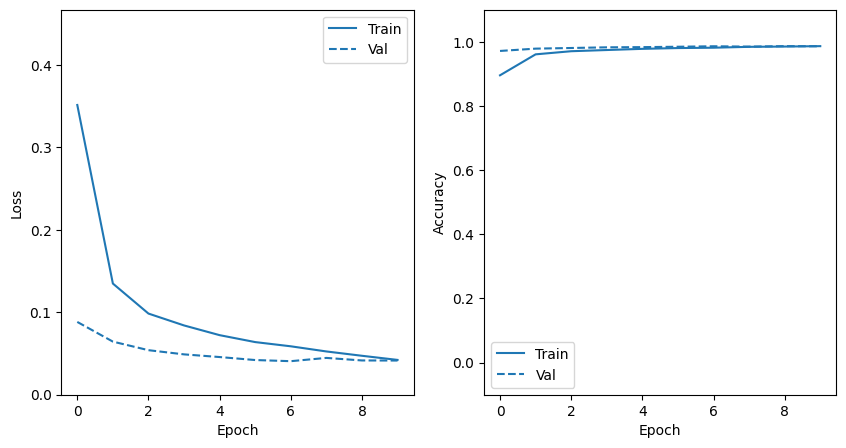

In [117]:
plot_metrics(model4_history)

In [118]:
loss, acc = model4.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.971


In [119]:
err = print_res(model4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [120]:
err

1

Here the accuracy goes up to 0.971 an outperform all models trained so far. However, this is also the most complex model with a total parameter size of 542230 parameters.

Model 4 parameters:
- Model Complexity (Paramereters) = 542230
- Accuracy: 0.971
- Test error in first 100 images: 1

Maybe we can reach a similar result with a larger kernel, since relevant features could also be detected on a larger part of the image than a 3x3 tile. Additionally, this would reduce the number of trainable parameters.

In [133]:
set_seeds()
model5 = make_model(32,9,2,True)
model5.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 20, 20, 32)     │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 100)            │       320,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 323,734 (1.23 MB)

 Trainable params: 323,734 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [134]:
model5_history = model5.fit(
    x_train,
    y_train,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8106 - loss: 0.6087 - val_accuracy: 0.9783 - val_loss: 0.0678
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9645 - loss: 0.1269 - val_accuracy: 0.9833 - val_loss: 0.0478
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9752 - loss: 0.0863 - val_accuracy: 0.9865 - val_loss: 0.0395
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9779 - loss: 0.0721 - val_accuracy: 0.9874 - val_loss: 0.0357
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9824 - loss: 0.0605 - val_accuracy: 0.9886 - val_loss: 0.0331
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9856 - loss: 0.0500 - val_accuracy: 0.9890 - val_loss: 0.0332
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9860 - loss: 0.0454 - val_accuracy: 0.9892 - val_loss: 0.0316
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9861 - loss: 0.0426 - val_accuracy: 0.

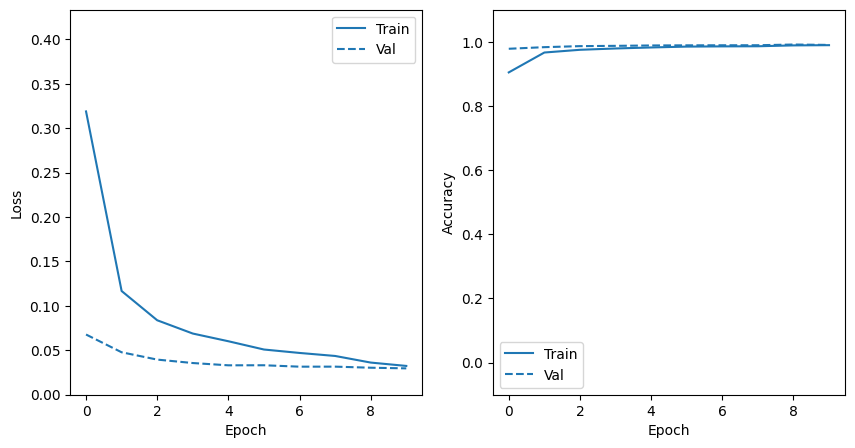

In [135]:
plot_metrics(model5_history)

In [136]:
loss, acc = model5.evaluate(x_test, y_test, verbose=0)
print('Accuracy: %.3f' % acc)

Accuracy: 0.992


In [137]:
err = print_res(model5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
9 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8

In [138]:
err

0